# AquaCrop-OSPy: Bridging the gap between research and practice in crop-water modelling


# Comparison with AquaCrop Windows

> AquaCrop-OSPy | AquaCrop-OS | AquaCrop | Test Comparison



## Excersise 7: Wheat production in Tunis

### From Chapter 7 of  <a href="../pdfs/AquaCrop_TrainingHandookB.pdf">AquaCrop Training Handbook</a> (pg. 64)

## Exercise 7.1: Assessing crop yield for local soils

### Imports

In [1]:
# uncomment if required
# !pip install aquacrop matplotlib seaborn

In [2]:

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement,FieldMngt
from aquacrop.utils import prepare_weather, get_filepath

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Run comparison

In [3]:
#model.Outputs.Final

In [4]:
#export
def run_comparison(model,name):
    """
    Function to run a comparison between python matlab and windows. 
    Plots yields and prints mean and mean absolute error between them
    
    Arguments: 

    
name (str): name of directory containing input files

    Returns:

    None

        
    """    
    Outputs = model._outputs
    
    py = Outputs.final_stats.round(3)
    py.columns = ["Season","CropType","HarvestDate","Harvest Date (Step)","Yield","Seasonal irrigation (mm)"]
    
    matlab = pd.read_csv(get_filepath(name+'_matlab.txt'),delim_whitespace=True,header=None)
    matlab.columns = ["season","crop","plantdate","stepplant","harvestdate","stepharvest","Yield","tirr"]

    
    windows_names = ('    RunNr     Day1   Month1    Year1     Rain      ETo       GD     CO2      Irri   Infilt   Runoff    Drain   Upflow        E     E/Ex       Tr      TrW   Tr/Trx    SaltIn   SaltOut    SaltUp  SaltProf     Cycle   SaltStr  FertStr  WeedStr  TempStr   ExpStr   StoStr  BioMass  Brelative   HI     Yield     WPet     DayN   MonthN    YearN'.split())
    windows = pd.read_csv(get_filepath(name+'_windows.OUT'),skiprows=5,delim_whitespace=True,names=windows_names,encoding="ISO-8859-1")

    combined = pd.DataFrame([py.Yield,windows.Yield,matlab.Yield]).T

    combined.columns = ["py", "windows","matlab"]
    mae = np.round(np.abs(combined.py - combined.windows).mean(),2)
    pymean = combined.mean().py.round(2)
    print(f'python seasonal mean: {pymean} kg/ha\nMAE from windows: {mae} kg/ha')
    
    mae_mat = np.round(np.abs(combined.py - combined.matlab).mean(),3)
    print(f'MAE from matlab:  {mae_mat} kg/ha')
    
    plt.style.use('seaborn')
    
    fig, ax = plt.subplots(2,1,sharex=True,figsize=(11,8))
    
    ax[0].plot(py.Yield,label='Python')
    ax[0].plot(matlab.Yield,label='Matlab')
    ax[0].plot(windows.Yield,'--',label='Windows')
    ax[0].legend(fontsize = 18)
    ax[0].set_ylabel('Yield',fontsize=18)
    
    #sns.jointplot(np.arange(len(py)), py.Yield - windows.Yield,
      #            kind="resid",color="m",ratio=10)
    
    ax[1].scatter(np.arange(len(py)),py.Yield - windows.Yield,label='Python')
    ax[1].scatter(np.arange(len(py)),matlab.Yield - windows.Yield,label='Matlab')
    ax[1].plot([0,len(py)],[0,0],'--',color='black')
    ax[1].set_xlabel('Season',fontsize=18)
    ax[1].set_ylabel('Residuals',fontsize=18)
    ax[1].legend(fontsize = 18)

    



    plt.show()
    
    
    return Outputs,windows

In [5]:
wdf = prepare_weather(get_filepath('tunis_climate.txt'))

soil=Soil(soil_type='ac_TunisLocal')
crop = Crop('WheatGDD',planting_date= '10/15')

iwc = InitialWaterContent('Num','Depth',[0.3,0.9],[0.3,0.15])

model = AquaCropModel('1979/10/15','2002/05/30',wdf,soil,crop,initial_water_content=iwc)



%time model.run_model(till_termination=True)

CPU times: user 1.42 s, sys: 4.93 ms, total: 1.42 s
Wall time: 1.42 s


True

python seasonal mean: 7.52 kg/ha
MAE from windows: 0.02 kg/ha
MAE from matlab:  0.002 kg/ha


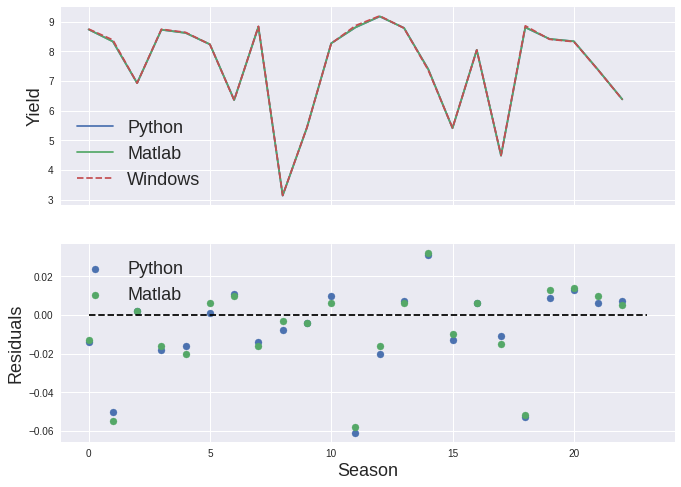

In [6]:
res = run_comparison(model,'tunis_test_1')

### Sandy loam soil

python seasonal mean: 8.64 kg/ha
MAE from windows: 0.01 kg/ha
MAE from matlab:  0.002 kg/ha


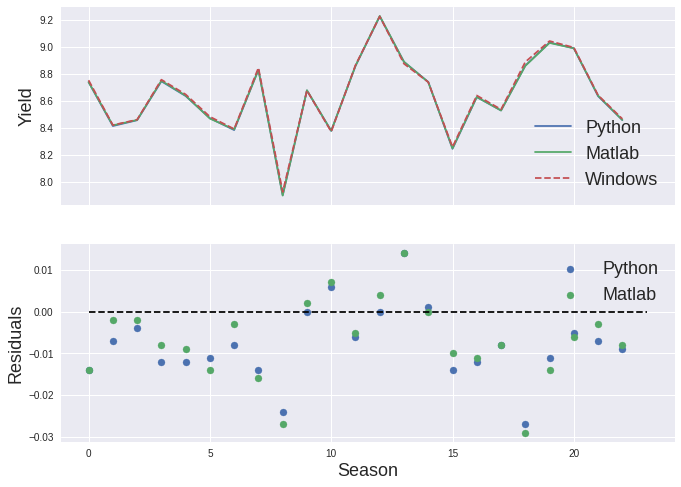

In [7]:
sandy_loam = Soil('SandyLoam')
model = AquaCropModel('1979/01/01','2002/05/30',wdf,sandy_loam,crop,initial_water_content=iwc)
model.run_model(till_termination=True)
res = run_comparison(model,'tunis_test_1_SandyLoam')

## Excercise 7.2 Local Wheat variety

In [8]:
local_wheat = Crop('WheatGDD',planting_date= '10/15',
                        Emergence=289, 
                        MaxRooting = 1322,
                        Senescence = 2835, 
                        Maturity = 3390,
                        HIstart = 2252,
                        Flowering = 264,
                        YldForm = 1073,
                        PlantPop=3_500_000,
                        CCx=0.9,
                        CDC=0.003888,
                        CGC=0.002734)

python seasonal mean: 8.68 kg/ha
MAE from windows: 0.04 kg/ha
MAE from matlab:  0.042 kg/ha


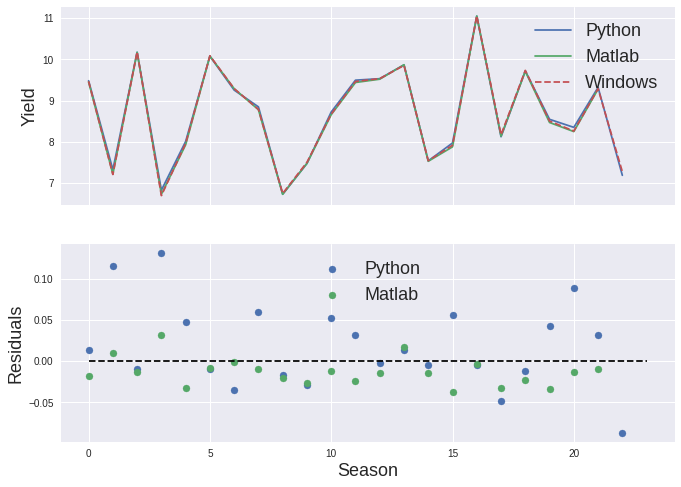

In [9]:
model = AquaCropModel('1979/01/01','2002/05/31',wdf,sandy_loam,local_wheat,initial_water_content=iwc)
model.run_model(till_termination=True)
_ = run_comparison(model,'tunis_test_2_long')

## Excercise 7.3 Different initial conditions

In [10]:
iwc30taw = InitialWaterContent('Pct','Layer',[1],[30])

python seasonal mean: 5.85 kg/ha
MAE from windows: 0.09 kg/ha
MAE from matlab:  0.002 kg/ha


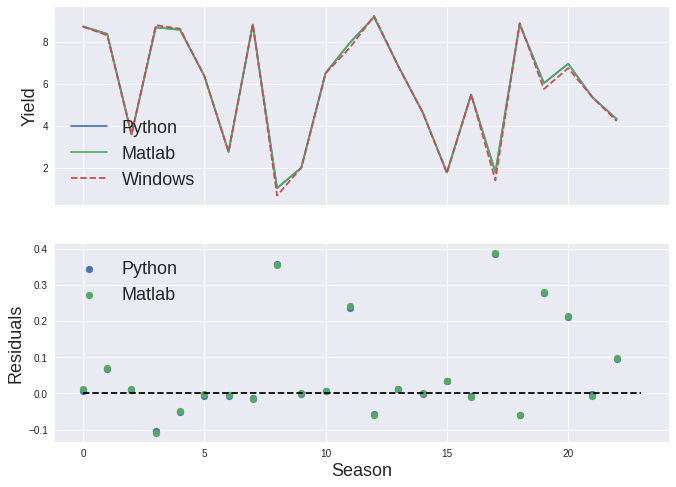

In [11]:
model = AquaCropModel('1979/01/01','2002/05/31',wdf,sandy_loam,
                      crop,initial_water_content=iwc30taw)

model.run_model(till_termination=True)
_ = run_comparison(model,'tunis_test_3_30taw')

## Excercise 7.6 Net irrigation requirement

In [12]:
net_irr = IrrigationManagement(irrigation_method=4,net_irr=78.26)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

python seasonal mean: 8.38 kg/ha
MAE from windows: 0.01 kg/ha
MAE from matlab:  0.003 kg/ha


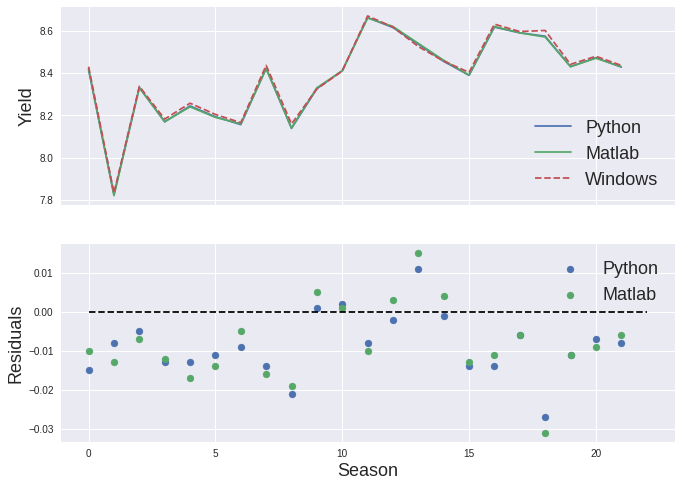

In [13]:
model = AquaCropModel('1979/08/15','2001/07/30',wdf,sandy_loam,
                      wheat_dec,initial_water_content=wp,irrigation_management=net_irr)
model.run_model(till_termination=True)
res = run_comparison(model,'tunis_test_6')

## Excersise 8 : Hyderabad : Chapter 8 of  <a href="../pdfs/AquaCrop_TrainingHandookB.pdf">AquaCrop Training Handbook</a>

## Excersise 8.1

In [14]:
wdf = prepare_weather(get_filepath('hyderabad_climate.txt'))

wdf.Date.min(),wdf.Date.max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2010-12-31 00:00:00'))

python seasonal mean: 6.43 kg/ha
MAE from windows: 0.01 kg/ha
MAE from matlab:  0.013 kg/ha


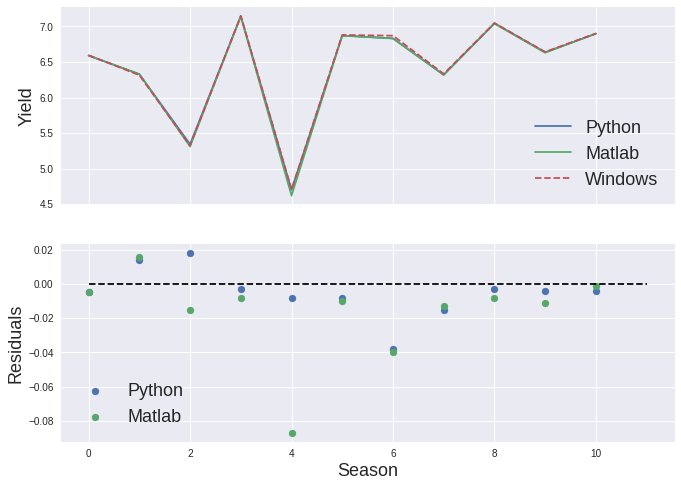

In [15]:
rice = Crop('localpaddy',planting_date= '08/01',)
paddy = Soil('Paddy')
iwc_paddy = InitialWaterContent(depth_layer=[1,2],value=['FC','FC'])
fm = FieldMngt(bunds=True,z_bund=0.2)
model = AquaCropModel('2000/01/01','2010/12/31',wdf,paddy,
                      rice,initial_water_content=iwc_paddy,field_management=fm,
                      fallow_field_management=fm)
model.run_model(till_termination=True)
_ = run_comparison(model,'paddyrice_hyderabad')

## Excersise 9 : Brussels : Chapter 9 of  <a href="../pdfs/AquaCrop_TrainingHandookB.pdf">AquaCrop Training Handbook</a>

### Excersise 9.1

In [16]:
wdf = prepare_weather(get_filepath('brussels_climate.txt'))

wdf.Date.min(),wdf.Date.max()

(Timestamp('1976-01-01 00:00:00'), Timestamp('2005-12-31 00:00:00'))

python seasonal mean: 9.69 kg/ha
MAE from windows: 0.1 kg/ha
MAE from matlab:  0.029 kg/ha


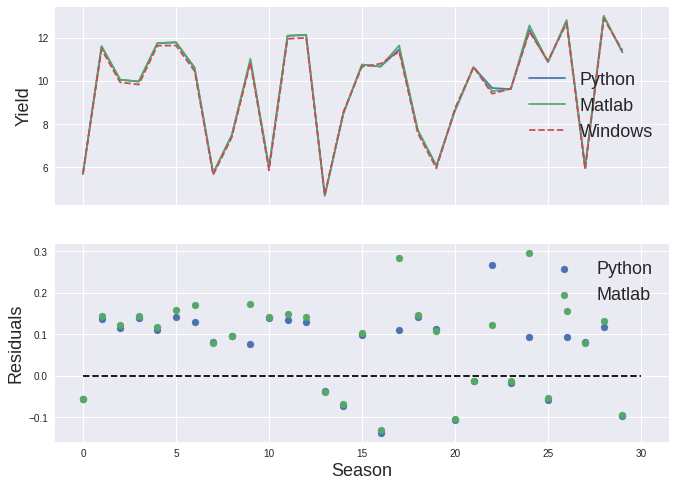

In [17]:
potato = Crop('PotatoLocal',planting_date= '04/25')
loam = Soil('Loam')
model = AquaCropModel('1976/01/01','2005/12/31',wdf,loam,potato,InitialWaterContent())
model.run_model(till_termination=True)
_ = run_comparison(model,'potato')

## Calculate RMSE for particular variables (for debugging)

In [18]:

windows_names = ('    RunNr     Day1   Month1    Year1     Rain      ETo       GD     CO2      Irri   Infilt   Runoff    Drain   Upflow        E     E/Ex       Tr      TrW   Tr/Trx    SaltIn   SaltOut    SaltUp  SaltProf     Cycle   SaltStr  FertStr  WeedStr  TempStr   ExpStr   StoStr  BioMass  Brelative   HI     Yield     WPet     DayN   MonthN    YearN'.split())
windows = pd.read_csv(get_filepath('potato'+'_windows.OUT'),skiprows=5,delim_whitespace=True,names=windows_names,encoding="ISO-8859-1")


In [19]:
infil = windows.Infilt.values
runoff = windows.Runoff.values
drain = windows.Drain.values
e = windows.E.values
tr = windows.Tr.values
bio = windows.BioMass*100
hi = windows.HI/100



In [20]:
grouped1 = model._outputs.crop_growth.groupby('season_counter').max()
grouped1.head()

,time_step_counter,dap,gdd,gdd_cum,z_root,canopy_cover,canopy_cover_ns,biomass,biomass_ns,harvest_index,harvest_index_adj,yield_
season_counter,,,,,,,,,,,,
-1.0,114.0,0.0,0.3,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
0.0,239.0,125.0,21.7,1884.25,0.6,0.862350,0.901142,727.594299,1336.718464,0.85,0.783289,5.699169
1.0,604.0,125.0,19.7,1604.70,0.6,0.919523,0.919523,1365.151078,1372.454625,0.85,0.849932,11.602858
2.0,969.0,125.0,20.7,1608.35,0.6,0.919523,0.919523,1200.169603,1376.180500,0.85,0.837747,10.054389
3.0,1334.0,125.0,20.0,1599.15,0.6,0.892085,0.901142,1191.474260,1373.349628,0.85,0.837168,9.974647


In [21]:
grouped = model._outputs.water_flux.groupby('season_counter').sum()
grouped.head()

,time_step_counter,dap,Wr,z_gw,surface_storage,IrrDay,Infl,Runoff,DeepPerc,CR,GwIn,Es,EsPot,Tr,TrPot
season_counter,,,,,,,,,,,,,,,
-1.0,6555.0,0.0,10019.89,-114885.0,0.0,0.0,131.882145,4.117855,71.117311,0.0,0.0,82.601730,135.080000,0.000000,0.000000
0.0,22125.0,7875.0,13719.62,-124875.0,0.0,0.0,148.172417,2.127583,0.000000,0.0,0.0,70.200175,223.026573,162.839113,304.919138
1.0,67750.0,7875.0,17299.10,-124875.0,0.0,0.0,303.077344,5.722656,48.054092,0.0,0.0,95.621728,139.812879,220.522103,220.566948
2.0,113375.0,7875.0,16867.71,-124875.0,0.0,0.0,307.410487,35.189513,105.719399,0.0,0.0,91.846257,138.356508,200.043602,229.744565
3.0,159000.0,7875.0,16196.70,-124875.0,0.0,0.0,270.007475,8.392525,30.311757,0.0,0.0,96.987000,137.950148,196.763470,225.579405


In [22]:
print('runoff',(((grouped.Runoff.values[1:]-runoff)**2).mean()**(0.5))/runoff.mean())
print('infil',(((grouped.Infl.values[1:]-infil)**2).mean()**(0.5))/infil.mean())
print('drain',(((grouped.DeepPerc.values[1:]-drain)**2).mean()**(0.5))/drain.mean())
print('es',(((grouped.Es.values[1:]-e)**2).mean()**(0.5))/e.mean())
print('tr',(((grouped.Tr.values[1:]-tr)**2).mean()**(0.5))/tr.mean())
print('bio',(((grouped1.biomass.values[1:]-bio)**2).mean()**(0.5))/bio.mean())
print('hi',(((grouped1.harvest_index.values[1:]-hi)**2).mean()**(0.5))/hi.mean())

runoff 0.028950898501130966
infil 0.001118950747288327
drain 0.018606817721937778
es 0.02097557914397535
tr 0.011832327627400175
bio 0.012778083976522187
hi 0.05034387357901827
